<a href="https://colab.research.google.com/github/StanleyLiangYork/2024_journal_club_Transformer_AI/blob/main/form_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements encoder of the transformer. The transformer encoder consists of a stack of N identical building blocks with two sub-units:

*   a multi-head attention mechanism that receives the queries, keys, and values as inputs.
*   a fully-connected feedforward network.

The sub-units are connected by the normalization for the sum of the inputs and the outputs

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q -U tensorflow-text tensorflow==2.15
!pip install -q tensorflow_dataset
!pip install -q --upgrade rouge-score
!pip install -q --upgrade keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow_dataset (from versions: none)
ERROR: No matching distribution found for tensorflow_dataset
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.7 MB/s eta 0:00:00


Download the Portuguese-English translation dataset with approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [ ]:
import tensorflow_datasets as tfds

examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.2GWICD_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.2GWICD_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.2GWICD_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


Take one batch (size=3) data and check

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('==== Examples in Portuguese ====')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print('==== The corresponding English')

  print('==== Examples in English ====')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

==== Examples in Portuguese ====
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
==== The corresponding English
==== Examples in English ====
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


# Set up the preprocessing pipeline.

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. We need two tokenizers - one for the source language (Portuguese), and the other for the target language (English).

We will use the keras_nlp.tokenizers.WordPieceTokenizer, which takes a WordPiece vocabulary and has functions for tokenizing the text, and detokenizing sequences of tokens.

The WordPiece tokenization algorithm is a subword tokenization algorithm; training it on a corpus gives us a vocabulary of subwords. A subword tokenizer is a compromise between word tokenizers (word tokenizers need very large vocabularies for good coverage of input words), and character tokenizers (characters don't really encode meaning like words do).

In [ ]:
import tensorflow as tf
import tensorflow.data as tf_data
import keras_nlp

def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf_data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [ ]:
len(train_examples)

51785

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

In [ ]:
# The methods of the tokenizers
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

create the tokenizers

In [ ]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(vocabulary=eng_vocab, lowercase=False)
pt_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(vocabulary=pt_vocab, lowercase=False)

In [ ]:
pt_examples, en_examples = next(iter(train_examples.batch(3)))
print('==== This is a batch of strings in English ====')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

# tokenize the string
encoded_en = tokenizers.en.tokenize(en_examples)

print('==== This is a batch of token IDs of English ====')
for row in encoded_en.to_list():
  print(row)
print("==== Recovered text after detokenizing ====")
word_restored = tokenizers.en.detokenize(encoded_en)
for text in word_restored.numpy():
  print(text.decode('utf-8'))
print()

print('==== This is a batch of strings in Portuguese ====')
for pt in pt_examples.numpy():
  print(pt.decode('utf-8'))

encoded_pt = tokenizers.pt.tokenize(pt_examples)

print('==== This is a batch of token IDs of Portuguese ====')
for row in encoded_pt.to_list():
  print(row)
print("==== Recovered text after detokenizing ==== ")
word_restored = tokenizers.pt.detokenize(encoded_pt)
for text in word_restored.numpy():
  print(text.decode('utf-8'))


==== This is a batch of strings in English ====
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
==== This is a batch of token IDs of English ====
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]
==== Recovered text after detokenizing ====
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .

==== This is a batch of strings in Portuguese ====
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
==== This is a batch of token IDs of Portug

# Prepare the dataset for the model
We cannot send the above data to the transformer model. In stead, we need to perform the following steps to format the raw data into a dataset good for machine learning. The dataset do the following things:

1.   Tokenizes them into ragged batches. (some rows are longer, the others are shorter)
2.   Trims all rows to be no longer than MAX_TOKENS.
3.   Splits the target (English) tokens into inputs (to learn) and labels (to check). These are shifted by one step so that at each input location the label is the id of the next token.
4.   Converts the RaggedTensors to padded dense Tensors, i.e. every row has the same length.
2.   Returns data as (inputs, labels) pair.

In [ ]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [ ]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 128)
(64, 128)
(64, 128)


In [ ]:
# the features and labels only have one shift to the right
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  72 175 197  76  84 106  37  56 459], shape=(10,), dtype=int64)
tf.Tensor([  72  175  197   76   84  106   37   56  459 4893], shape=(10,), dtype=int64)


# Positional encoding

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.
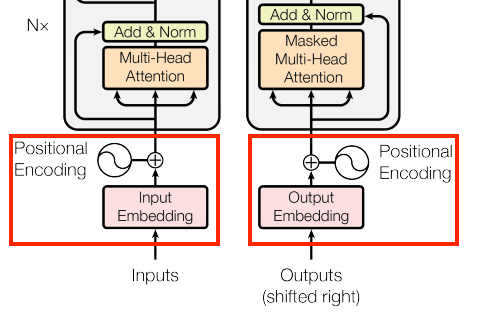

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a bag of words instance. For example, *how are you, how you are, you how are,* and so on are the same and these sequence indistinguishable.

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function uses a stack of sine and cosine function values that vibrate at different frequencies depending on their location along the dimension / columns of the embedding vector. They vibrate across the position axis.

(2048, 512)


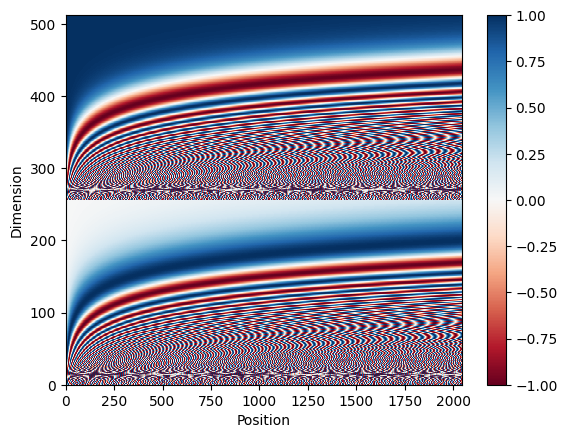

In [ ]:
import matplotlib.pyplot as plt
# embed a sequence fragment with the length of 2048 and 512 dimension (columns)
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Dimension')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Implement the PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector to the embeddings

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

Check the positional embedding

In [ ]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

In [ ]:
pt = pt_examples[0]
en = en_examples[0]
print(pt)
print(en)

tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)
tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)


In [191]:
for (pt, en), en_labels in train_batches.take(1):
  break
pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [194]:
print(pt_emb.shape, en_emb.shape)

(64, 128, 512) (64, 124, 512)


In [192]:
# the mask to prevent the decoder from looking at the succeeding tokens
en_emb._keras_mask

<tf.Tensor: shape=(64, 124), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

**The components of the transformer encoder**

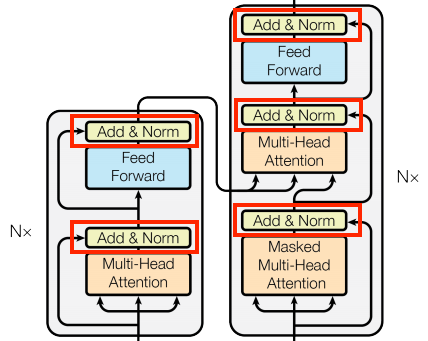

# The base attention layer

The attention layer with the Add & Normalization is one of the basic building blocks for the encoder block.

We first build a base attention layer to better explain the attention mechanism. The base attention layer is **the template of other attention layers**.

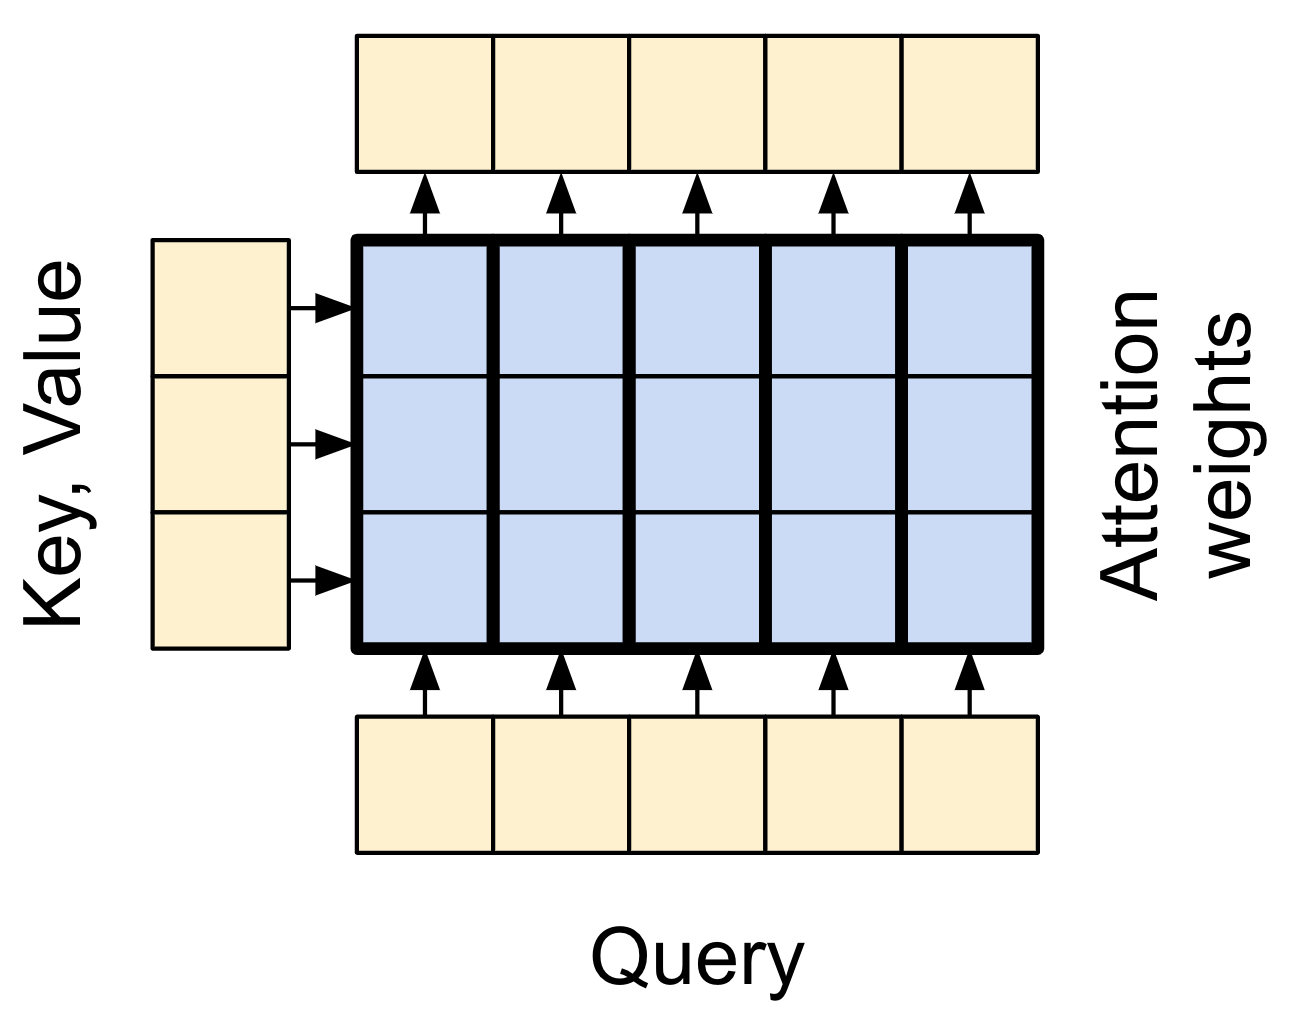

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [197]:
sample_ba = BaseAttention(num_heads=4, key_dim=512) # passed to the MultiHeadAttention layer

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ba(en_emb, pt_emb).shape)

(64, 128, 512)
(64, 124, 512)
(64, 124, 512)


There are two inputs:

The query sequence; the sequence being processed; the sequence doing the

*   The query sequence (Query): the sequence being processed; the sequence doing the attending (bottom).
*   The context sequence (Key & Value): the sequence being attended to (left).

Think about a dictionary having keys and values. The keys are the terms to be looked up, the values are the detailed explanation the users actually want.
On the other hand, the dictionary cannot always find a perfect match, but you can find a similar term to satisfy your search. If you looked up d["species"] in the dictionary above, maybe you'd want it to return "pickup" since that's the best match for the query. An attention layer does a fuzzy lookup like this, but it's not just looking for the best key. It uses its knowledge learned from the train to combine the values based on how well the query matches each key.

In an attention layer, the **query, key, and value** are vectors. Instead of doing a perfect lookup, the attention layer combines the query and key vectors to determine how well they match by the "attention score". The layer returns the average across all the values, weighted by the "attention scores".

# The cross attention layer

The cross-attention layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model.
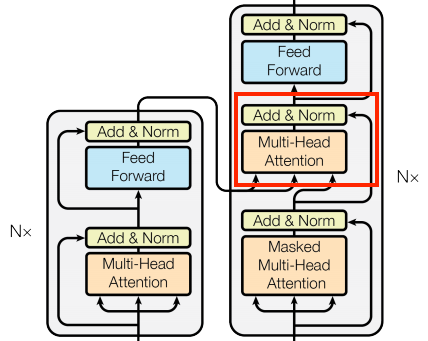

The cross-attention layer takes the target sequence x (English) as the query and the context sequence (Portuguese) as the key/value when calling the mha layer:




In [ ]:
# the cross-attention layer is a sub-class of the base attention layer.
# thus it inherits the multi-head attention, normalization, and add method.

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Test the cross attention layer with 4 heads

In [193]:
sample_ca = CrossAttention(num_heads=4, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape) # English as query, Portuguese as key / value

(64, 128, 512)
(64, 124, 512)
(64, 124, 512)


# Global self-attention layer

The global self-attention layer is for the encoder side. It processes the context sequence, and propagating information along its length. Information is allowed to flow in both directions. (no mask)

 We pass the target sequence x (Portuguese), as query, kay, and value arguments to the multi-head attention layer

In [201]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

sample_gsa = GlobalSelfAttention(num_heads=4, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 128, 512)
(64, 128, 512)


# Causal self-attention layer

The causal self-attention layer is for the decoder side. Transformer is autoregressive. It generates the text one token at a time and feed that output back to the input. It ensures that the output for each sequence element only depends on the previous sequence elements.

To build a causal self-attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention values. So we set the use_causal_mask = True in the MultiHeadAttention layer.

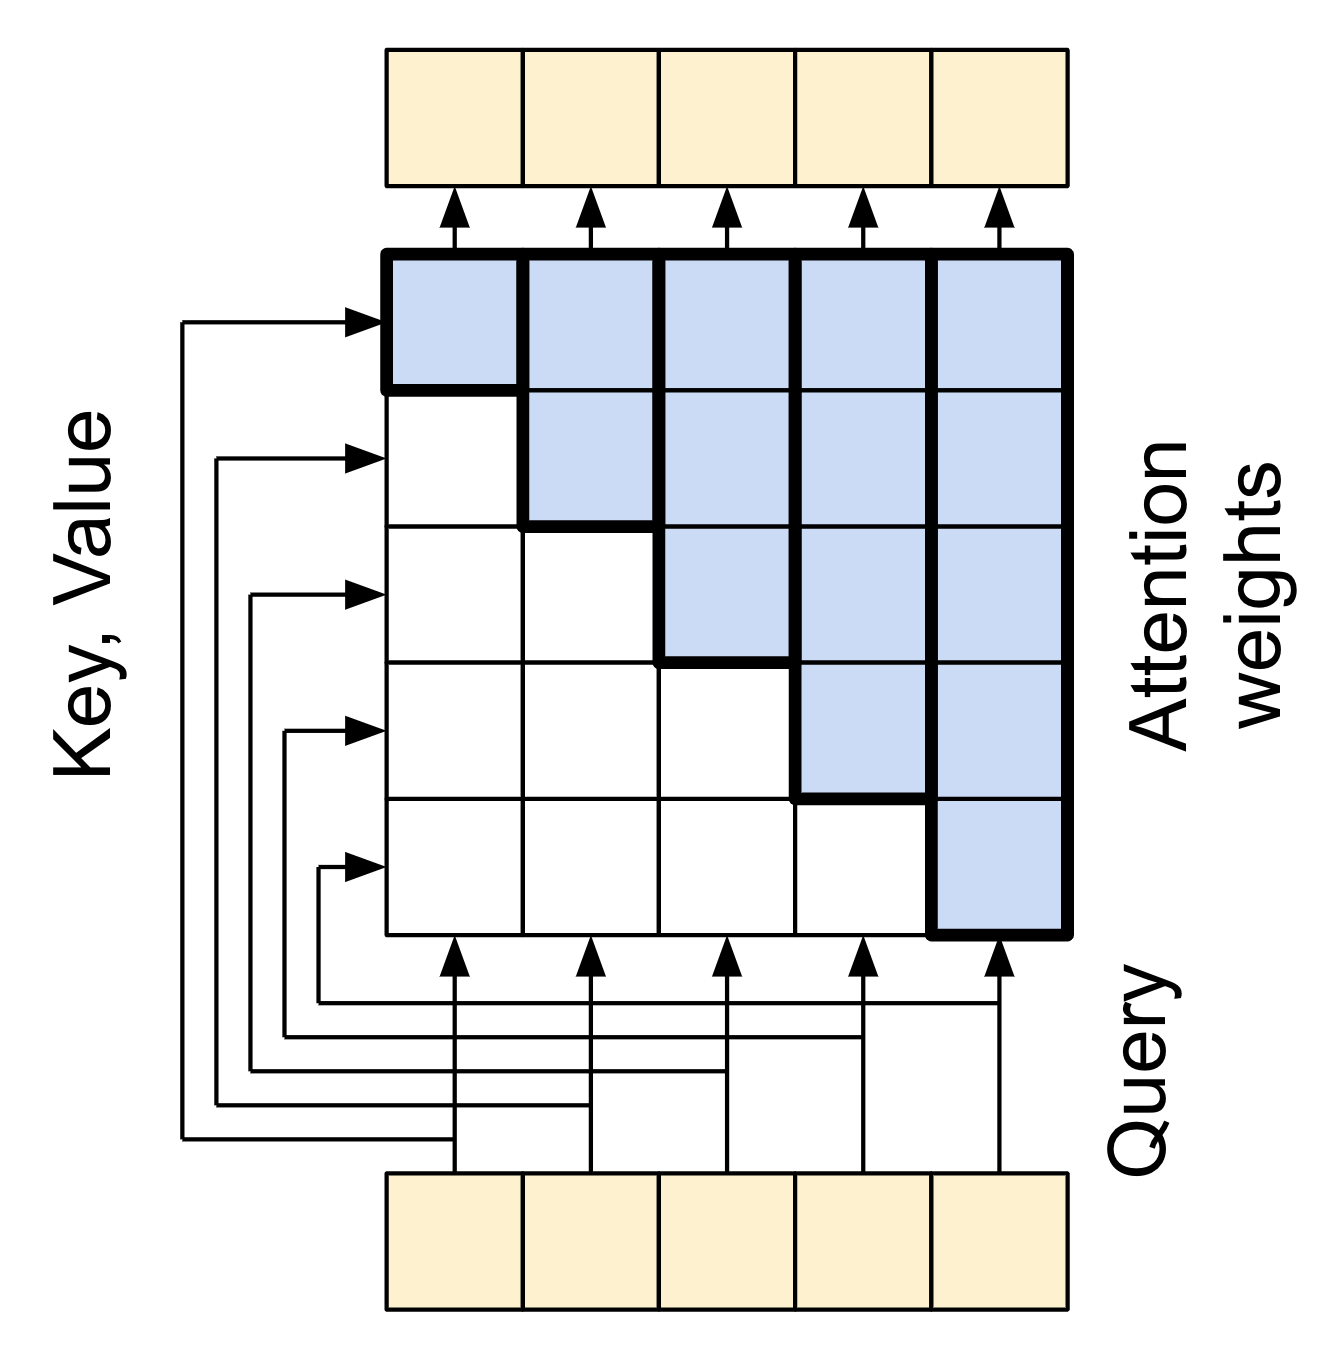

In [200]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [202]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 124, 512)
(64, 124, 512)


# Feed forward network
The feed forward network consists of two linear layers (Dense) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization.

In [203]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [204]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 124, 512)
(64, 124, 512)


# The encoder layer

The encoder contains a stack of N encoder block units (encoder layer). Where each encoder block contains a GlobalSelfAttention and FeedForward layer.

In [205]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [206]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 128, 512)
(64, 128, 512)


# The encoder

The encoder consists of:

*   A PositionalEmbedding layer at the input.
*   A stack of EncoderLayer layers.

In [207]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [208]:
sample_encoder = Encoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

In [209]:
# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 128)
(64, 128, 512)


# The decoder layer

In the decoder layer, we need to replace the global attention with causal attention, add the cross attention to connect it to the encoder, and add the FeedForward layer to the attention layer

In [219]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [220]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 124, 512)
(64, 128, 512)
(64, 124, 2048)


# The decoder
The decoder consists of a PositionalEmbedding, and a stack of DecoderLayers:

In [221]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [222]:
# create a decoder with stack of 4
sample_decoder = Decoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000)

output = sample_decoder(x=en, context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 124)
(64, 128, 512)
(64, 124, 2048)


In [215]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 124, 128])

# Form the transformer model

To complete the Transformer model, we need to put the encoder and decoder together and add a final linear (Dense) layer which converts the resulting vector at each location into output token probabilities.

In [223]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [217]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [224]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [225]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 124)
(64, 128)
(64, 124, 7010)


In [226]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 124, 128)


In [227]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  8304640   
                                                                 
 decoder_3 (Decoder)         multiple                  15827456  
                                                                 
 dense_56 (Dense)            multiple                  3596130   
                                                                 
Total params: 27728226 (105.77 MB)
Trainable params: 27728226 (105.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
